In [1]:
# IMAGE PROCESSING
import cv2 # OpenCV library
import numpy as np # Numpy library for matricies
import random
import math
from matplotlib import pyplot as plt # Matplotlib library for plotting
from collections import deque
import heapq

random.seed(42)

In [2]:
# General settings
seed = 42
# image_file = "maze1234.png"
image_file = "continuous_maze_1_cropped.jpeg"

# Occupancy map
unsafe_iterations = 3

# BFS
size_of_node_grid = 9
bfs_start_node = 0
bfs_end_node = 99

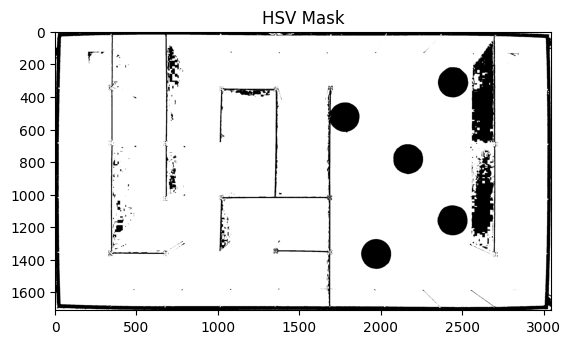

In [3]:
# Loading in the image
image = cv2.imread(image_file)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

lower = np.array([0, 8, 104]) # 0 0 102
upper = np.array([179, 255, 255]) # 179 255 224

hsv_mask = cv2.inRange(hsv_image, lower, upper)

# Display the mask
plt.figure(1)
plt.imshow(hsv_mask, cmap='gray')
plt.title("HSV Mask")

plt.show()

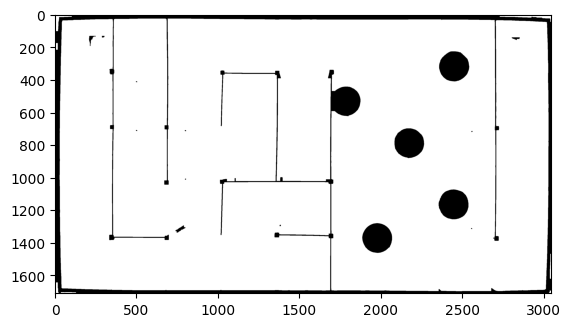

In [4]:
# Applying Erosion + Dilation to the Image

kernel = np.ones((7, 7), np.uint8)
kernel3 = np.ones((3, 3), np.uint8)
kernel4 = np.ones((2, 2), np.uint8)
    
# Loading in the image
image = cv2.imread(image_file)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

lower = np.array([0, 0, 104]) # 0 0 102
upper = np.array([179, 255, 225]) # 179 255 224

hsv_mask = cv2.inRange(hsv_image, lower, upper)

# Applying erosion to generate unsafe area
eroded_image = cv2.erode(hsv_mask, kernel, iterations = unsafe_iterations)

kernel2 = np.ones((4, 4), np.uint8)

# Applying dilation to clean up the image
dilated_image = cv2.dilate(eroded_image, kernel2, iterations = 6)
dilated_image2 = cv2.dilate(dilated_image, kernel3, iterations = 2)
erode_image2 = cv2.erode(dilated_image2, kernel4, iterations = 2)
dilTE123 = cv2.dilate(erode_image2,kernel4,iterations = 2)
erode123 = cv2.erode(dilTE123,kernel4,iterations = 3)

# Displays resulting image
gray_image = plt.imshow(erode123, cmap='gray')
plt.show(gray_image)

# # grayscale_image = hsv_image[:,:,2]

# grayscale_image = cv2.cvtColor(erode123, cv2.COLOR_HSV2BGR)
# grayscale_image = cv2.cvtColor(grayscale_image, cv2.COLOR_BGR2GRAY)

# plt.imshow(grayscale_image)
# plt.show()

# # erodes the white == expanding the black
# image_erode = cv2.erode(grayscale_image, kernel, iterations=unsafe_iterations)

# # XOR: 0 XOR 0 = 0, 1 XOR 1 = 0
# # 0 xor 1 = 1, 1 xor 0 = 1 
# # therefore, the differences will be highlighted, the differences being the new black squares from erosion and 
# # the original image
# red_mask = cv2.bitwise_xor(grayscale_image, image_erode)

# # Red color in BGR format
# # Opposite of red layer since we're gonna be subtracting this from the image 
# # so that white colors are turned into red
# red_layer = np.zeros_like(image)
# red_layer[:, :] = [0, 255, 255] 

# unsafe_area_image = cv2.bitwise_and(red_layer, red_layer, mask=red_mask)

# # image = cv2.subtract(image, unsafe_area_image)

# # Subtract the unsafe area from the original image
# image = cv2.subtract(image, unsafe_area_image)
# plt.imshow(image)

# # # Display the final image with highlighted unsafe areas
# # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# # Display resulting image
# plt.show()

In [5]:
class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x, self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {} # Keys are node IDs, Values are node objects
        self.edges = {} # Keys are node IDs, Values are objects containing neighbouring node ID and the weight

    def add_node(self, node_id, x, y):
        if node_id not in self.nodes:
            self.nodes[node_id] = Node(node_id, x, y)
            self.edges[node_id] = {}

    def add_edge(self, node_id1, node_id2, weight):
        if node_id1 in self.nodes and node_id2 in self.nodes:
            # Edges are bi-directional
            self.edges[node_id1][node_id2] = weight
            self.edges[node_id2][node_id1] = weight

    def remove_edge(self, node_id1, node_id2):
        if node_id1 in self.edges and node_id2 in self.edges[node_id1]:
            # Edges are bi-directional
            del self.edges[node_id1][node_id2]
            del self.edges[node_id2][node_id1]
    
    def get_nodes(self):
        return list(self.nodes.keys())
    
    def get_edge_weight(self, node_id1, node_id2):
        if node_id1 in self.edges and node_id2 in self.edges[node_id1]:
            return self.edges[node_id1][node_id2]
        return None
    
    def get_nodes_dict(self):
        return self.nodes
    
    def get_edges_dict(self):
        return self.edges

In [6]:
def path_clear(image, x1, y1, x2, y2):
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy
    
    while True:
        if image[y1, x1].tolist() == [0, 0, 0]:
            return False
        if x1 == x2 and y1 == y2:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
#             err += dx
            y1 += sy
    return True

def find_distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def prm_path_clear(image, x1, y1, x2, y2):
    
    distance = int(round(find_distance(x1, y1, x2, y2)))
    
    x_points = np.linspace(x1, x2, distance)
    y_points = np.linspace(y1, y2, distance)
    
    x_points = np.round(x_points).astype(int)
    y_points = np.round(y_points).astype(int)
    
    last_val = None
    for x, y in zip(x_points, y_points):
        
        if last_val is None:
            last_val = image[y, x]
        else:
            if last_val != image[y, x]:
                return False
            else: 
                last_val = image[y, x]

    return True

def find_neighbours(graph, node_id):
    neighbours = []
    nodes = graph.get_nodes()
    for node in nodes:
        print('4')
        if graph.get_edge_weight(node_id, node) is not None and node != node_id:
            neighbours.append(node_id)
    return neighbours

def dijkstra(graph, start_id, goal_id):
    queue = [(0, start_id)]
    distances = {node.get_ID(): float('inf') for node in list(graph.get_nodes_dict().values())}
    distances[start_id] = 0
    parent = {node.get_ID(): None for node in list(graph.get_nodes_dict().values())}
    while queue:
        current_distance, current_id = heapq.heappop(queue)        
        if current_id == goal_id:
            break       
        for neighbor_id, weight in graph.edges[current_id].items():
            distance = current_distance + weight            
            if distance < distances[neighbor_id]:
                distances[neighbor_id] = distance
                parent[neighbor_id] = current_id
                heapq.heappush(queue, (distance, neighbor_id))    
    path = []
    current_id = goal_id
    while parent[current_id] is not None:
        path.insert(0, current_id)
        current_id = parent[current_id]
    path.insert(0, start_id)   
    return path, distances[goal_id]

[0, 36, 38, 2, 6, 32, 44, 8]
rrflflfrfrrfrrflf


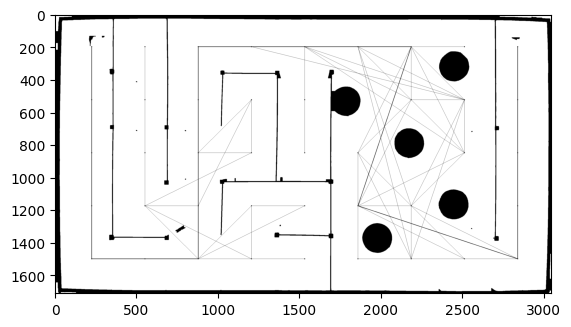

In [7]:
grid_image = erode123.copy()
# grid_image = cv2.cvtColor(erode123, cv2.COLOR_HSV2BGR)
height, width = grid_image.shape
# node_spacing_x = (width // (size_of_node_grid + 1))
# node_spacing_y = (height // (size_of_node_grid + 1))

x_nodes = 9
y_nodes = 5

node_spacing_x = width // (x_nodes + 1)
node_spacing_y = height // (y_nodes + 1)

# spacing right now is hard coded, need to watch out if the camera shifts or anything when taking photo

custom_node_spacing_y = 325
custom_node_spacing_x = 2950 // 9

bfs_graph = Graph()

# The following loops were generated with the help of ChatGPT:]

node_id = 0
for i in range(y_nodes):
    for j in range(x_nodes):
        x = 225 + j * custom_node_spacing_x
        y = 200 + i * custom_node_spacing_y
         
        bfs_graph.add_node(node_id, x, y)
        node_id += 1

# Creating nodes
# node_id = 0
# for i in range(1, size_of_node_grid + 1):
#     for j in range(1, size_of_node_grid + 1):
#         x = j * node_spacing_x
#         y = i * node_spacing_y
         
#         bfs_graph.add_node(node_id, x, y)
#         node_id += 1

# # Adding edges
# for i in range(size_of_node_grid):
#     for j in range(size_of_node_grid):
#         current_node_id = i * size_of_node_grid + j
#         x, y = bfs_graph.nodes[current_node_id].get_point()
#         # Connecting to the right with a weight of 1
#         if j + 1 < size_of_node_grid:
#             right_node_id = current_node_id + 1
#             if path_clear(grid_image, x, y, x + node_spacing_x, y):
#                 bfs_graph.add_edge(current_node_id, right_node_id, 1)
#         # Connecting down with a weight of 1
#         if i + 1 < size_of_node_grid:
#             down_node_id = current_node_id + size_of_node_grid
#             if path_clear(grid_image, x, y, x, y + node_spacing_y):
#                 bfs_graph.add_edge(current_node_id, down_node_id, 1)

nodes = bfs_graph.get_nodes()


for node_id in nodes:
    node_x, node_y = bfs_graph.nodes[node_id].get_point()
#     if node_id + 1 in nodes and node_id not in [8, 17, 26, 35, 44] != 0:
#         right_node_x, right_node_y = bfs_graph.nodes[node_id + 1].get_point()
#         if prm_path_clear(grid_image, node_x, node_y, right_node_x, right_node_y):
#             bfs_graph.add_edge(node_id, node_id + 1, 1)
#     if node_id + 9 in nodes:
#         down_node_x, down_node_y = bfs_graph.nodes[node_id + 9].get_point()
#         if prm_path_clear(grid_image, node_x, node_y, down_node_x, down_node_y):
#             bfs_graph.add_edge(node_id, node_id + 9, 1)

    for node_id_2 in nodes:
        if node_id_2 == node_id:
            continue
        node_2_x, node_2_y = bfs_graph.nodes[node_id_2].get_point()
        if prm_path_clear(grid_image, node_x, node_y, node_2_x, node_2_y):
            bfs_graph.add_edge(node_id, node_id_2, 1)

# Displaying nodes as light green circles with radius 3
for node_id in bfs_graph.get_nodes():
    node_obj = bfs_graph.nodes[node_id]
    x,y = node_obj.get_point();
    cv2.circle(grid_image, node_obj.get_point(), 3, (0, 255, 0), -1)

# Displaying edges as dark green lines with width 1
for node_id in bfs_graph.get_nodes():
    for neighbour_id, weight in bfs_graph.edges[node_id].items():
        node_obj = bfs_graph.nodes[node_id]
        neighbour_obj = bfs_graph.nodes[neighbour_id]
        cv2.line(grid_image, node_obj.get_point(), neighbour_obj.get_point(), (0, 125, 0), 1)

# Labeling first and last nodes
# cv2.putText(grid_image, '0', bfs_graph.nodes[0].get_point(), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
# cv2.putText(grid_image, '99', bfs_graph.nodes[size_of_node_grid*size_of_node_grid - 1].get_point(), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# continuous part starts on the 6th column and ends on the 9th

# nodes: 5 + 9... 

continuous_start = list(range(5, 42, 9))

# for i in continuous_start:
#     path, cost = dijkstra(bfs_graph, 0, i)
#     if path:
#         for node in path: 
#             if node in continuous_start and node != path[-1]:
#                 # if a valid path is found, but the path goes through the continuous start, don't use this path
#                 # and keep searching for a path that starts at tge continuous part
#                 continue
#         break

path, cost = dijkstra(bfs_graph, 0, 8)

print(path)

# converting path to commands
# looking at our code right now, i think there are 2 options
# 1. make the turning function be able to turn to any orientation (need it for continuous planning anyways),
#    then we can just call move forward and turn to whatever orientation we need
# 2. if we want to keep the maze movement as just forward, left and right then we'd need to keep track of 
#    the robots current orientation

# could try 2 since its simpler rn and we alr have turn left turn right
# for 2: 
# could identify 0, 1, 2, 3 as forward, right, down, left from the robot's current orientation, then
# keep track of the robot's current orientation and do (turn direction = global direction - current orientation)
# e.g. say robot's facing down (2), and the next path is right (1), then 1 - 2 = -1 + 4 = 3 therefore need to 
#      turn left

# + 4 if negative until positive

commands = ''

for i in range(1, len(path)):
    last_node = bfs_graph.nodes[path[i - 1]]
    curr_node = bfs_graph.nodes[path[i]]
    cv2.line(grid_image, curr_node.get_point(), last_node.get_point(), (0, 0, 255), 2)
    
    if curr_node.get_point()[0] - last_node.get_point()[0] < 0:
        global_dir = 3
    elif curr_node.get_point()[0] - last_node.get_point()[0] > 0:
        global_dir = 1
    elif curr_node.get_point()[1] - last_node.get_point()[1] < 0: 
        global_dir = 0
    elif curr_node.get_point()[1] - last_node.get_point()[1] > 0: 
        global_dir = 2
        
    if i == 1: 
        last_dir = 0
    else: 
        if bfs_graph.nodes[path[i-1]].get_point()[0] - bfs_graph.nodes[path[i-2]].get_point()[0] < 0:
            last_dir = 3
        elif bfs_graph.nodes[path[i-1]].get_point()[0] - bfs_graph.nodes[path[i-2]].get_point()[0] > 0:
            last_dir = 1
        elif bfs_graph.nodes[path[i-1]].get_point()[1] - bfs_graph.nodes[path[i-2]].get_point()[1] < 0: 
            last_dir = 0
        elif bfs_graph.nodes[path[i-1]].get_point()[1] - bfs_graph.nodes[path[i-2]].get_point()[1] > 0: 
            last_dir = 2
    
    next_dir = global_dir - last_dir
    
    if next_dir < 0: 
        next_dir += 4
    
    # strings format following what we used on our demo 
    # using two right turns to turn 180
    if next_dir == 0:
        commands += 'f'
    elif next_dir == 1: 
        commands += 'rf'
    elif next_dir == 2: 
        commands += 'rrf'
    elif next_dir == 3:
        commands += 'lf'

print(commands)
    
# Displaying resulting image
plt.imshow(grid_image, cmap='gray')
plt.show()
